## NES-LTER: Comparison between CTD and sampled chlorophyll concentration estimates

This notebook combines chlorophyll concentration estimates derived from a CTD-mounted fluorometer with corresponding estaimates derived from lab processing of samples. This enables confirming that the estimates match, which aids in the decision of when to take samples.

First, read chlorophyll and CTD data from GitHub

In [1]:
import pandas as pd

BASE_URL = 'https://raw.githubusercontent.com/WHOIGit/nes-lter-examples/master/data/'

chl = pd.read_csv(BASE_URL + 'neslter_sosik_chl.csv')
btl = pd.read_csv(BASE_URL + 'en608_btl.csv')

Samples are replicated, so the chlorophyll concentration needs to be averaged across those replicates. This uses a function called `average_replicates`

In [2]:
def average_replicates(chl, replicates=['a','b'], var='chl'):
    rows = []
    # group by cruise, cast, niskin, and filter mesh size
    for ccnf, sdf in chl.groupby(['cruise','cast','niskin','filter_mesh_size']):
        # remove all rows except the replicates we want
        sdf_reps = sdf[sdf['replicate'].isin(replicates)]
        # average the variable
        var_average = sdf_reps[var].mean()
        # construct the output row
        row = ccnf + (var_average,)
        rows.append(row)
    return pd.DataFrame(rows, columns=['cruise','cast','niskin','filter_mesh_size',var])

In [3]:
chl_avg = average_replicates(chl)

# now only include WSW
chl_avg = chl_avg[chl_avg['filter_mesh_size'] == '>0']
chl_avg.head()

,cruise,cast,niskin,filter_mesh_size,chl
0,AR22,2,2,>0,0.483914
2,AR22,3,3,>0,0.274832
3,AR22,3,5,>0,1.575510
4,AR22,4,6,>0,0.608864
5,AR22,5,1,>0,0.168525


Now the two datasets need to be collated so that they align on cruise, cast, and niskin bottle number.

The column containing CTD-derived data is called `fleco_afl` and the one containing the sample-derived data is called `chl`.

In [4]:
# merge sample and CTD data per-niskin
merged = btl.merge(chl_avg, on=['cruise','cast','niskin'])

# display a few rows to make sure we're doing it right
merged[['cruise','cast','niskin','chl','fleco_afl','par']].head()

,cruise,cast,niskin,chl,fleco_afl,par
0,EN608,1,2,5.737033,3.9609,4.395900e+00
1,EN608,1,5,5.174035,2.9635,2.574600e+01
2,EN608,1,9,5.387947,2.5430,1.283600e+02
3,EN608,1,19,5.344230,1.7145,6.749100e+02
4,EN608,19,1,0.014856,0.0020,1.000000e-12


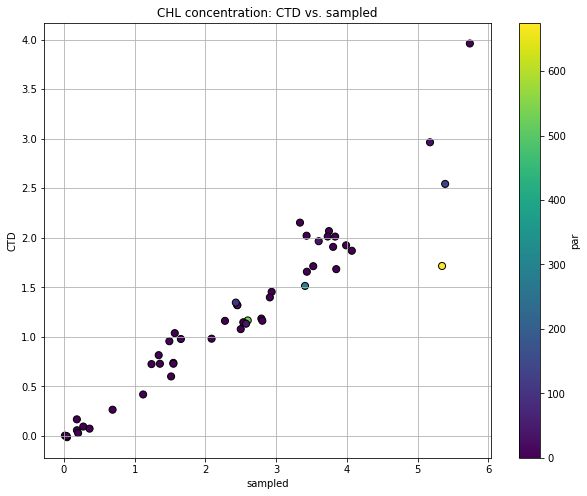

In [5]:
%matplotlib inline

# now plot CTD against sampled data
ax = merged.plot.scatter(
    x='chl',
    y='fleco_afl',
    c='par',
    s=50,
    cmap='viridis',
    edgecolor='black',
    title='CHL concentration: CTD vs. sampled',
    grid=True,
    figsize=(10,8),
    sharex=False
)
ax.set_xlabel('sampled')
ax.set_ylabel('CTD');